In [8]:
import pandas as pd
import glob
import collections
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 

# Functions

In [9]:
def fix(s):
    firstcolon = s.find(":")
    s_new = s[firstcolon-2:firstcolon] + s[firstcolon+1:firstcolon+3]
    s_new = s_new.replace("*", "0")
    return s_new

def compute_resolution(gs_val,pre_val):
    gs_all = gs_val.split("/")
    pre_fixed = fix(pre_val)
    flag = False #false = inaccurate, turn to true = 2 digits accurate
    
    for val in gs_all:
        gs_fixed = fix(val)

        if (gs_fixed[0:2] == pre_fixed[0:2]):
            if (gs_fixed[2:4] == pre_fixed[2:4]):
                return 4
            flag = True
        
    return 2 if flag==True else 0

In [10]:
# requirements: gs accession numbers are under a column labeled "Run" 
#pre accession numbers are under a column labeled "ERR" 
# accession numbers/column titles are labeled identically between gold standard and results csv
# Only accuracy for samples in both GS and PRE are calculated. Samples in PRE, but not in GS are ignored. Samples in GS, but not in PRE, are tallied in the "failed" variable 
def get_inaccurate_alleles(pre,gs):

    zerodig = []
    all_alleles = [] # holds all alleles in gold standard
    fail = 0

    accession_numbers = gs['Run'].values.tolist()
    genes = gs.columns.values.tolist()

    for number in accession_numbers:
        pre_row = pre.loc[pre['ERR'] == number]
        gs_row = gs.loc[gs['Run'] == number]
        
        
        # if we are working with d5 or d6, the monoallelic datasets
        if (gs.columns.tolist() == ['Run', 'A', 'B'] or gs.columns.tolist() == ['Run', 'C']):
            for i in range(1,len(genes)):
                gs_val = gs_row[genes[i]].astype(str).values[0]
                pre_val1 = pre_row[genes[i]].astype(str).values[0]
                pre_val2 = pre_row[genes[i]+".1"].astype(str).values[0]
                
                # if the gold standard contains many allele possibilities, and the caller is incorrect,
                # we will return only the first value in the gs
                gs_primary = gs_row[genes[i]].astype(str).values[0].split("/")[0]
                all_alleles.append(gs_primary)

                ans1 = compute_resolution(gs_val,pre_val1)
                ans2 = compute_resolution(gs_val,pre_val2)
                if (max(ans1,ans2) == 0):
                    zerodig.append(gs_primary)

        # if we are working with d1-d4, the biallelic datasets
        else:
            for i in range(1,len(genes),2):
                try:
                    gs_val1 = gs_row[genes[i]].astype(str).values[0]
                    pre_val1 = pre_row[genes[i]].astype(str).values[0]
                    gs_val2 = gs_row[genes[i+1]].astype(str).values[0]
                    pre_val2 = pre_row[genes[i+1]].astype(str).values[0]

                    if (gs_val1 == None) or (pre_val1 == None) or (gs_val2 == None) or (pre_val2 == None):
                        fail = fail+1
                        continue
                        
                    # if the gold standard contains many allele possibilities, and the caller is incorrect,
                    # we will return only the first value in the gs
                    gs_primary = gs_row[genes[i]].astype(str).values[0].split("/")[0]
                    all_alleles.append(gs_primary)

                    # assuming no swapping 
                    ans1 = compute_resolution(gs_val1,pre_val1)
                    ans2 = compute_resolution(gs_val2,pre_val2)

                    # assuming swapping
                    ans3 = compute_resolution(gs_val1,pre_val2)
                    ans4 = compute_resolution(gs_val2,pre_val1)

                    if (ans1+ans2 > ans3+ans4):
                        if (ans1 == 0):
                            zerodig.append(gs_primary)
                        if (ans2 == 0):
                            zerodig.append(gs_primary)
                    else:
                        if (ans3 == 0):
                            zerodig.append(gs_primary)
                        if (ans4 == 0):
                            zerodig.append(gs_primary)
                except:
                    fail = fail+1

    return zerodig, all_alleles #,fail #onzero fail indicates exception occurred

# Mismatch

In [63]:
tool_list=["arcas","hlaforest","hlavbseq","optitype","phlat","rna2hla","seq2hla","hlahd"]
#tool_list=["hlavbseq"]

missed_alleles = []

for t in tool_list:
    missed_alleles_caller = []
    for i in range(1,7):
        gs=pd.read_csv(f"../datasets/{i}_gs.csv")
        pre=pd.read_csv(f"../results/standard/{t}_d{i}.csv")
    
        ret = get_inaccurate_alleles(pre,gs)
        missed_alleles_caller.append(ret[0])
    missed_alleles.append(missed_alleles_caller)



In [64]:
mis_total = []
all_total = np.array([1084, 1080, 1088, 1180, 980]) #5 element vector with # of gold standard A, B, C, DRB, and DQB

for tool in missed_alleles:
    mis_counts = [0,0,0,0,0]
    for d in tool:
        for allele in d:
            if allele[0] == "A":
                mis_counts[0]+=1
            if allele[0] == "B":
                mis_counts[1] += 1
            if allele[0] == 'C':
                mis_counts[2] += 1
            if allele[0:2] == 'DR':
                mis_counts[3] += 1
            if allele[0:2] == 'DQ':
                mis_counts[4] += 1
    mis_total.append(mis_counts)

percentage = mis_total/all_total
print(percentage)

[[0.01383764 0.01574074 0.01654412 0.02627119 0.00306122]
 [0.01476015 0.07685185 0.01470588 0.02457627 0.02653061]
 [0.08210332 0.11481481 0.09742647 0.88220339 0.95714286]
 [0.00276753 0.01111111 0.00551471 0.         0.        ]
 [0.00830258 0.05925926 0.02665441 0.02457627 0.39591837]
 [0.00369004 0.02222222 0.02205882 0.06779661 0.        ]
 [0.00369004 0.02222222 0.02205882 0.10254237 0.07040816]
 [0.06549815 0.05185185 0.05790441 0.06355932 0.06326531]]


# Plots

In [65]:
df = pd.DataFrame(mis_total)
df.columns = ['A','B','C','DRB1','DQB1']
df.index = ["arcas","hlaforest","hlavbseq","optitype","phlat","rna2hla","seq2hla","hlahd"]
df

,A,B,C,DRB1,DQB1
arcas,15,17,18,31,3
hlaforest,16,83,16,29,26
hlavbseq,89,124,106,1041,938
optitype,3,12,6,0,0
phlat,9,64,29,29,388
rna2hla,4,24,24,80,0
seq2hla,4,24,24,121,69
hlahd,71,56,63,75,62


In [66]:
df = pd.DataFrame(percentage)
df.columns = ['A','B','C','DRB1','DQB1']
df.index = ["arcas","hlaforest","hlavbseq","optitype","phlat","rna2hla","seq2hla","hlahd"]
df

,A,B,C,DRB1,DQB1
arcas,0.013838,0.015741,0.016544,0.026271,0.003061
hlaforest,0.014760,0.076852,0.014706,0.024576,0.026531
hlavbseq,0.082103,0.114815,0.097426,0.882203,0.957143
optitype,0.002768,0.011111,0.005515,0.000000,0.000000
phlat,0.008303,0.059259,0.026654,0.024576,0.395918
rna2hla,0.003690,0.022222,0.022059,0.067797,0.000000
seq2hla,0.003690,0.022222,0.022059,0.102542,0.070408
hlahd,0.065498,0.051852,0.057904,0.063559,0.063265


<AxesSubplot:>

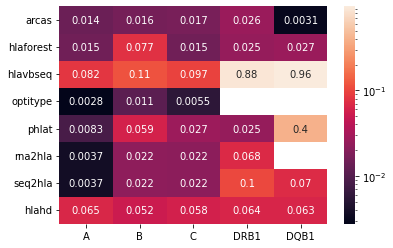

In [67]:
from matplotlib.colors import LogNorm, Normalize
sns.heatmap(df,annot=True,norm=LogNorm())